In [24]:
import numpy as np
import os
import pandas as pd
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Embedding
from torch.nn import Parameter
from torch_geometric.data import Data,DataLoader
from torch_geometric.nn import GCNConv
from torch_geometric.utils import to_undirected

In [25]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [27]:
device

device(type='cpu')

## Data Preparation

In [29]:
# Load Dataframe
df_edge = pd.read_csv('Dataset/elliptic_txs_edgelist.csv')
df_class = pd.read_csv('Dataset/elliptic_txs_classes.csv')
df_features = pd.read_csv('Dataset/elliptic_txs_features.csv',header=None)

# Setting Column name
df_features.columns = ['id', 'time step'] + [f'trans_feat_{i}' for i in range(93)] + [f'agg_feat_{i}' for i in range(72)]

print('Number of edges: {}'.format(len(df_edge)))

Number of edges: 234355


In [30]:
all_nodes = list(set(df_edge['txId1']).union(set(df_edge['txId2'])).union(set(df_class['txId'])).union(set(df_features['id'])))
nodes_df = pd.DataFrame(all_nodes,columns=['id']).reset_index()

print('Number of nodes: {}'.format(len(nodes_df)))

Number of nodes: 203769


In [31]:
df_edge = df_edge.join(nodes_df.rename(columns={'id':'txId1'}).set_index('txId1'),on='txId1',how='inner') \
       .join(nodes_df.rename(columns={'id':'txId2'}).set_index('txId2'),on='txId2',how='inner',rsuffix='2') \
       .drop(columns=['txId1','txId2']) \
       .rename(columns={'index':'txId1','index2':'txId2'})
df_edge.head()

,txId1,txId2
0,153797,56594
1,56482,137562
3575,153261,137562
1387,153677,137562
6890,170229,137562


In [32]:
df_class = df_class.join(nodes_df.rename(columns={'id':'txId'}).set_index('txId'),on='txId',how='inner') \
        .drop(columns=['txId']).rename(columns={'index':'txId'})[['txId','class']]
df_class.head()

,txId,class
0,153797,unknown
1,56594,unknown
2,56482,unknown
3,137562,2
4,161328,unknown


In [33]:
df_features = df_features.join(nodes_df.set_index('id'),on='id',how='inner') \
        .drop(columns=['id']).rename(columns={'index':'id'})
df_features = df_features [ ['id']+list(df_features.drop(columns=['id']).columns) ]
df_features.head()

,id,time step,trans_feat_0,trans_feat_1,trans_feat_2,trans_feat_3,trans_feat_4,trans_feat_5,trans_feat_6,trans_feat_7,...,agg_feat_62,agg_feat_63,agg_feat_64,agg_feat_65,agg_feat_66,agg_feat_67,agg_feat_68,agg_feat_69,agg_feat_70,agg_feat_71
0,153797,1,-0.171469,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162097,...,-0.562153,-0.600999,1.461330,1.461369,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
1,56594,1,-0.171484,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162112,...,0.947382,0.673103,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
2,56482,1,-0.172107,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162749,...,0.670883,0.439728,-0.979074,-0.978556,-0.098889,-0.106715,-0.131155,-0.183671,-0.120613,-0.119792
3,137562,1,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558,-0.163645,...,-0.577099,-0.613614,0.241128,0.241406,1.072793,0.085530,-0.131155,0.677799,-0.120613,-0.119792
4,161328,1,1.011523,-0.081127,-1.201369,1.153668,0.333276,1.312656,-0.061584,-0.163523,...,-0.511871,-0.400422,0.517257,0.579382,0.018279,0.277775,0.326394,1.293750,0.178136,0.179117


In [34]:
df_edge_time = df_edge.join(df_features[['id','time step']].rename(columns={'id':'txId1'}).set_index('txId1'),on='txId1',how='left',rsuffix='1') \
.join(df_features[['id','time step']].rename(columns={'id':'txId2'}).set_index('txId2'),on='txId2',how='left',rsuffix='2')
df_edge_time['is_time_same'] = df_edge_time['time step'] == df_edge_time['time step2']
df_edge_time_fin = df_edge_time[['txId1','txId2','time step']].rename(columns={'txId1':'source','txId2':'target','time step':'time'})

In [35]:
df_features.drop(columns=['time step']).to_csv('data/elliptic_txs_features.csv',index=False,header=None)
df_class.rename(columns={'txId':'nid','class':'label'})[['nid','label']].sort_values(by='nid').to_csv('data/elliptic_txs_classes.csv',index=False,header=None)
df_features[['id','time step']].rename(columns={'id':'nid','time step':'time'})[['nid','time']].sort_values(by='nid').to_csv('data/elliptic_txs_nodetime.csv',index=False,header=None)
df_edge_time_fin[['source','target','time']].to_csv('data/elliptic_txs_edgelist_timed.csv',index=False,header=None)

## Graph Pre-processing

In [36]:
node_label = df_class.rename(columns={'txId':'nid','class':'label'})[['nid','label']].sort_values(by='nid').merge(df_features[['id','time step']].rename(columns={'id':'nid','time step':'time'}),on='nid',how='left')
node_label['label'] =  node_label['label'].apply(lambda x: '3'  if x =='unknown' else x).astype(int)-1
node_label.head()

,nid,label,time
0,0,1,17
1,1,2,13
2,2,1,10
3,3,2,27
4,4,2,31


In [37]:
merged_nodes_df = node_label.merge(df_features.rename(columns={'id':'nid','time step':'time'}).drop(columns=['time']),on='nid',how='left')
merged_nodes_df.head()

,nid,label,time,trans_feat_0,trans_feat_1,trans_feat_2,trans_feat_3,trans_feat_4,trans_feat_5,trans_feat_6,...,agg_feat_62,agg_feat_63,agg_feat_64,agg_feat_65,agg_feat_66,agg_feat_67,agg_feat_68,agg_feat_69,agg_feat_70,agg_feat_71
0,0,1,17,0.218933,0.048298,-1.201369,2.054118,-0.063725,1.480381,2.981378,...,-0.577099,-0.613614,0.241128,0.241406,0.135448,-0.068266,-0.131155,-0.011377,-0.120613,-0.119792
1,1,2,13,-0.167004,-0.178843,0.463609,-0.121970,-0.024025,-0.113002,-0.061584,...,3.447003,2.346677,0.289197,0.851388,-0.098889,-0.049041,-0.030745,-0.068808,-1.194450,-0.940388
2,2,1,10,-0.172886,-0.184668,-1.201369,0.178180,-0.043875,0.222447,-0.061584,...,-0.577099,-0.588384,0.241128,0.241406,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
3,3,2,27,-0.068066,-0.172527,0.463609,-0.121970,-0.043875,-0.113002,-0.061584,...,-0.577099,-0.613614,0.241128,0.241406,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
4,4,2,31,-0.172141,-0.128652,0.463609,-0.121970,-0.043875,-0.113002,-0.061584,...,-0.479951,-0.531617,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792


In [38]:
train_dataset=[]
test_dataset=[]
for i in range(49):
    nodes_df_tmp=merged_nodes_df[merged_nodes_df['time']==i+1].reset_index()
    nodes_df_tmp['index']=nodes_df_tmp.index
    df_edge_tmp = df_edge_time_fin.join(nodes_df_tmp.rename(columns={'nid':'source'})[['source','index']].set_index('source'),on='source',how='inner')\
        .join(nodes_df_tmp.rename(columns={'nid':'target'})[['target','index']].set_index('target'),on='target',how='inner',rsuffix='2') \
        .drop(columns=['source','target']) \
        .rename(columns={'index':'source','index2':'target'})
    x = torch.tensor(np.array(nodes_df_tmp.sort_values(by='index').drop(columns=['index','nid','label'])), dtype=torch.float)
    edge_index = torch.tensor(np.array(df_edge_tmp[['source','target']]).T, dtype=torch.long)
    edge_index = to_undirected(edge_index)
    mask = nodes_df_tmp['label']!=2
    y=torch.tensor(np.array(nodes_df_tmp['label']))

    
    if i+1<35:
        data = Data(x=x,edge_index=edge_index, train_mask=mask, y=y)
        train_dataset.append(data)
    else:
        data = Data(x=x,edge_index=edge_index, test_mask=mask, y=y)
        test_dataset.append(data)

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


## GCN Model

In [39]:
class GCN(torch.nn.Module):
    def __init__(self, num_node_features, hidden_channels, use_skip=False):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_node_features, hidden_channels[0])
        self.conv2 = GCNConv(hidden_channels[0], 2)
        self.use_skip = use_skip
        if self.use_skip:
            self.weight = nn.init.xavier_normal_(Parameter(torch.Tensor(num_node_features, 2)))


    def forward(self, data):
        x = self.conv1(data.x, data.edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, data.edge_index)
        if self.use_skip:
            x = F.softmax(x+torch.matmul(data.x, self.weight), dim=-1)
        else:
            x = F.softmax(x, dim=-1)
        return x

    def embed(self, data):
        x = self.conv1(data.x, data.edge_index)
        return x

In [40]:
model = GCN(num_node_features=data.num_node_features ,hidden_channels=[100])
model.to(device)

GCN(
  (conv1): GCNConv(166, 100)
  (conv2): GCNConv(100, 2)
)

## Training the GCN Model

#### Hyperparameters

In [41]:
patience = 50
lr = 0.001
epoches = 1000

In [45]:
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = torch.nn.CrossEntropyLoss(weight=torch.tensor([0.7,0.3]).to(device))


train_losses=[]
val_losses =[]
accuracies=[]
if1=[]
precisions=[]
recalls=[]
iterations=[]


for epoch in range(epoches):
    
    model.train()
    train_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out[data.train_mask], data.y[data.train_mask].to(torch.int64))
        _, pred = out[data.train_mask].max(dim=1)
        loss.backward()
        train_loss += loss.item() * data.num_graphs
        optimizer.step()
    train_loss /= len(train_loader.dataset)
    

    if (epoch+1)%50==0:
        model.eval()
        ys, preds = [], []
        val_loss = 0
        for data in test_loader:
            data = data.to(device)
            out = model(data)
            loss = criterion(out[data.test_mask], data.y[data.test_mask].to(torch.int64))
            val_loss += loss.item() * data.num_graphs
            _, pred = out[data.test_mask].max(dim=1)
            ys.append(data.y[data.test_mask].cpu())
            preds.append(pred.cpu())

        y, pred = torch.cat(ys, dim=0).numpy(), torch.cat(preds, dim=0).numpy()
        val_loss /= len(test_loader.dataset)
        f1 = f1_score(y, pred, average=None)
        mf1 = f1_score(y, pred, average='micro')
        precision = precision_score(y, pred, average=None)
        recall = recall_score(y, pred, average=None)

        iterations.append(epoch+1)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        if1.append(f1[0])
        accuracies.append(mf1)
        precisions.append(precision[0])
        recalls.append(recall[0])

        print('Epoch: {:02d}, Train_Loss: {:.4f}, Val_Loss: {:.4f}, Precision: {:.4f}, Recall: {:.4f}, Illicit f1: {:.4f}, F1: {:.4f}'.format(epoch+1, train_loss, val_loss, precision[0], recall[0], f1[0], mf1))






Epoch: 50, Train_Loss: 0.3649, Val_Loss: 0.3974, Precision: 0.7818, Recall: 0.5226, Illicit f1: 0.6265, F1: 0.9595
Epoch: 100, Train_Loss: 0.3604, Val_Loss: 0.3962, Precision: 0.7666, Recall: 0.5429, Illicit f1: 0.6357, F1: 0.9596
Epoch: 150, Train_Loss: 0.3575, Val_Loss: 0.3977, Precision: 0.8320, Recall: 0.4986, Illicit f1: 0.6236, F1: 0.9609
Epoch: 200, Train_Loss: 0.3555, Val_Loss: 0.3944, Precision: 0.7665, Recall: 0.5577, Illicit f1: 0.6456, F1: 0.9602
Epoch: 250, Train_Loss: 0.3539, Val_Loss: 0.3954, Precision: 0.7878, Recall: 0.5383, Illicit f1: 0.6396, F1: 0.9606
Epoch: 300, Train_Loss: 0.3532, Val_Loss: 0.3949, Precision: 0.7816, Recall: 0.5485, Illicit f1: 0.6446, F1: 0.9607
Epoch: 350, Train_Loss: 0.3522, Val_Loss: 0.3957, Precision: 0.8424, Recall: 0.5134, Illicit f1: 0.6380, F1: 0.9621
Epoch: 400, Train_Loss: 0.3514, Val_Loss: 0.3972, Precision: 0.8567, Recall: 0.5023, Illicit f1: 0.6333, F1: 0.9622
Epoch: 450, Train_Loss: 0.3506, Val_Loss: 0.3968, Precision: 0.8688, Reca

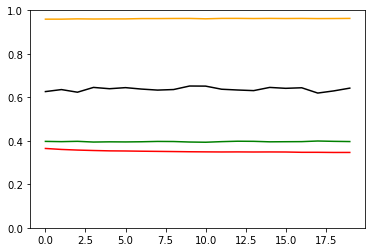

In [51]:
a,b,c,d = train_losses, val_losses, if1, accuracies
plt.plot(np.array(a), 'r', label='Train loss')
plt.plot(np.array(b), 'g', label='Valid loss')
plt.plot(np.array(c), 'black', label='Illicit F1')
plt.plot(np.array(d), 'orange', label='F1')
plt.ylim([0,1.0])
plt.show()

In [59]:
torch.save(model.state_dict(), "Models/GCN_Model")